In [103]:
import pandas as pd
import pickle
import requests
import numpy as np
from yahooquery import Ticker
import datetime
from datetime import date
import urllib.request
import sys
import json
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import re

In [104]:
delta1 = datetime.timedelta(days=3)
delta3 = datetime.timedelta(days=-4)
today = date.today()
one_day_ahead = date.today() + delta1
three_days_behind = date.today() +delta3

In [105]:
holiday = pd.read_csv('../data/holiday.csv')

In [106]:
ticker = Ticker('XLF')

In [107]:
XLE = ticker.history(period='3mo', interval='1d', adj_timezone=False)['adjclose'].unstack().T


In [108]:
future = pd.date_range(str(date.today()), str(one_day_ahead), freq='1d', tz='UTC')

In [109]:
future_df = pd.DataFrame(index=future)

In [110]:
XLE = pd.concat([XLE, future_df])

In [111]:
XLE.index = pd.to_datetime(XLE.index)
XLE['year'] = XLE.index.year
XLE['dayofyear'] =XLE.index.dayofyear

In [112]:
XLE.rename(columns={'XLF':'Adj Close'}, inplace=True)

In [113]:
XLE['Adj_Close_30D_lag'] = XLE['Adj Close'].shift(freq='28D')
XLE['Adj_Close_60D_lag'] = XLE['Adj Close'].shift(freq='56D')
XLE['Adj_Close_30D_lag'] = XLE['Adj_Close_30D_lag'].ffill()
XLE['Adj_Close_60D_lag'] = XLE['Adj_Close_60D_lag'].ffill()

In [114]:
locations2 = ['Los%20Angeles', 'Tampa', 'Austin','new%20york%20city']

In [115]:
weather_df = pd.DataFrame()
try:
    for loc in locations2:
        ResultBytes = urllib.request.urlopen(f"https://weather.visualcrossing.com/VisualCrossingWebServices/"
                                             f"rest/services/timeline/{loc}/{three_days_behind}/{one_day_ahead}?"
                                             f"unitGroup=us&include=fcst%2Chours%2Cobs&"
                                             f"key=WREBBANRZ6AS2Q7XGN9MPALGF&contentType=json")

      # Parse the results as JSON
        jsonData = json.load(ResultBytes)
        for i in range(len(jsonData['days'])):
            day = pd.DataFrame(jsonData['days'][i]['hours'])
            day['name'] = loc.replace('%20',' ')
            weather_df = pd.concat([weather_df,day])

except urllib.error.HTTPError  as e:
  ErrorInfo= e.read().decode()
  print('Error code: ', e.code, ErrorInfo)
  sys.exit()
except  urllib.error.URLError as e:
  ErrorInfo= e.read().decode()
  print('Error code: ', e.code,ErrorInfo)
  sys.exit()

In [116]:
locations =[ "CISO", "ERCO","NYIS","FLA"]

In [117]:
def json_to_dateframe(response):
    return pd.DataFrame(response.json()['response']['data'][1:], columns= response.json()['response']['data'][0])

In [118]:
key = 'sTv4JWSnbR70W7WbCrXWepkOviLnFKxbsVHbIL1C'

In [119]:
from time import sleep
energy = pd.DataFrame()
for loc in locations:
    try:
        url = f'https://api.eia.gov/v2/electricity/rto/region-data/data/?frequency=hourly&data[0]=value&facets[respondent][]={loc}&facets[type][]=D&facets[type][]=NG&start={str(three_days_behind)}T00&end={str(today)}T00&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000&api_key={key}'
        response = requests.get(url)
        df = json_to_dateframe(response)
        energy = pd.concat([energy, df])
    except:
        print('error')

In [120]:
demand = energy.query("type == 'D' ")

In [121]:
demand['respondent-name'] = demand['respondent-name'].replace('Florida', 'Florida Power and Light').copy()
demand['period'] = pd.to_datetime(demand.period)
demand['period'] = pd.to_datetime(demand.period)

In [122]:
respondents =['Electric Reliability Council of Texas, Inc.' ,
              'New York Independent System Operator',
              'Florida Power and Light' ,
               'California Independent System Operator',]

In [123]:
demand['name'] = demand['respondent-name']

In [124]:
demand['name'] = demand['name'].replace(respondents[3], 'Los Angeles')
demand['name'] = demand['name'].replace(respondents[2], 'Tampa')
demand['name'] = demand['name'].replace(respondents[0], 'Austin')
demand['name'] = demand['name'].replace(respondents[1], 'new york city')

In [125]:
weather_df['period'] = pd.to_datetime(weather_df.datetimeEpoch, unit='s')

In [126]:
demand_weather = pd.merge(demand,weather_df, how='right', on=['name','period'],suffixes=('','2'))
demand_weather = demand_weather.set_index(demand_weather.period)
demand_weather= demand_weather.drop(columns=['type','type-name','datetime','datetimeEpoch','stations','solarenergy','source','severerisk','preciptype','windgust','value-units','respondent','icon','conditions'])

In [127]:
demand_weather['year'] = demand_weather.index.year
demand_weather['month'] = demand_weather.index.month
demand_weather['days'] = demand_weather.index.dayofweek
demand_weather['hour'] = demand_weather.index.hour
demand_weather['quarter'] = demand_weather.index.quarter
demand_weather['dayofyear'] = demand_weather.index.dayofyear
demand_weather["Is Weekend"] = demand_weather.index.day_name().isin(['Saturday', 'Sunday'])

In [128]:
demand_weather = pd.merge(demand_weather,XLE,how='left', on=['year','dayofyear'])

In [129]:
holidays =holiday.drop('Date',axis=1)
demand_weather = pd.merge(demand_weather,holidays, how='outer', on=['year','dayofyear'])

In [130]:
demand_weather['solarradiation'] = demand_weather['solarradiation'].bfill()
demand_weather['uvindex'] = demand_weather['uvindex'].bfill()
demand_weather['snow'] = demand_weather['snow'].bfill()
demand_weather['Adj Close'] = demand_weather['Adj Close'].bfill()

In [131]:
demand_weather.loc[demand_weather['name'] == 'Los Angeles', 'respondent-name'] = 'California Independent System Operator'
demand_weather.loc[demand_weather['name'] == 'new york city', 'respondent-name'] = 'New York Independent System Operator'
demand_weather.loc[demand_weather['name'] == 'Tampa', 'respondent-name'] = 'Florida Power and Light'
demand_weather.loc[demand_weather['name'] == 'Austin', 'respondent-name'] = 'Electric Reliability Council of Texas, Inc.'

In [132]:
demand_weather = demand_weather.set_index('period')
demand_weather.index = pd.to_datetime(demand_weather.index)
demand_weather.rename(columns={'respondent-name':'respondent','pressure': 'sealevelevelpressure'}, inplace=True)

In [133]:
demand_weather = pd.get_dummies(demand_weather, columns=['Holiday','Is Weekend'], drop_first=True, dtype=float)
new_names = {col: re.sub(r'[^A-Za-z0-9_]+', '', col) for col in demand_weather.columns}
new_n_list = list(new_names.values())
# [LightGBM] Feature appears more than one time.
new_names = {col: f'{new_col}_{i}' if new_col in new_n_list[:i] else new_col for i, (col, new_col) in enumerate(new_names.items())}
demand_weather = demand_weather.rename(columns=new_names)

In [146]:
NY = demand_weather.query("respondent== 'New York Independent System Operator'")
FL = demand_weather.query("respondent == 'Florida Power and Light'")
CA = demand_weather.query("respondent ==  'California Independent System Operator'")
TX = demand_weather.query("respondent ==  'Electric Reliability Council of Texas, Inc.'")

In [147]:
NY['demand_3d_lag'] = NY['value'].shift(72)
FL['demand_3d_lag'] = FL['value'].shift(72)
CA['demand_3d_lag'] = CA['value'].shift(72)
TX['demand_3d_lag'] = TX['value'].shift(72)

In [148]:
NY['24_hours_ahead'] = NY['temp'].shift(-24)
FL['24_hours_ahead'] = FL['temp'].shift(-24)
CA['24_hours_ahead'] = CA['temp'].shift(-24)
TX['24_hours_ahead'] = TX['temp'].shift(-24)

In [149]:
TX = TX[~TX.index.duplicated(keep='first')]
NY = NY[~NY.index.duplicated(keep='first')]
CA = CA[~CA.index.duplicated(keep='first')]
FL = FL[~FL.index.duplicated(keep='first')]

In [150]:
TX  = TX.iloc[TX.index >= str(today)]
NY  = NY.iloc[NY.index >= str(today)]
CA  = CA.iloc[CA.index >= str(today)]
FL  = FL.iloc[FL.index >= str(today)]

In [151]:
Features = TX.columns[3:]

In [152]:
TX_X = TX[Features]
NY_X = NY[Features]
CA_X = CA[Features]
FL_X = FL[Features]

In [153]:
TX_X = TX_X.dropna(subset=['demand_3d_lag'])
NY_X = NY_X.dropna(subset=['demand_3d_lag'])
CA_X = CA_X.dropna(subset=['demand_3d_lag'])
FL_X = FL_X.dropna(subset=['demand_3d_lag'])

In [154]:
filename = R'model_TX.pkl'
with open(filename,'rb') as f:
    model = pickle.load(f)

In [155]:
TX_X['pred'] = model.predict(TX_X)

<Axes: xlabel='period'>

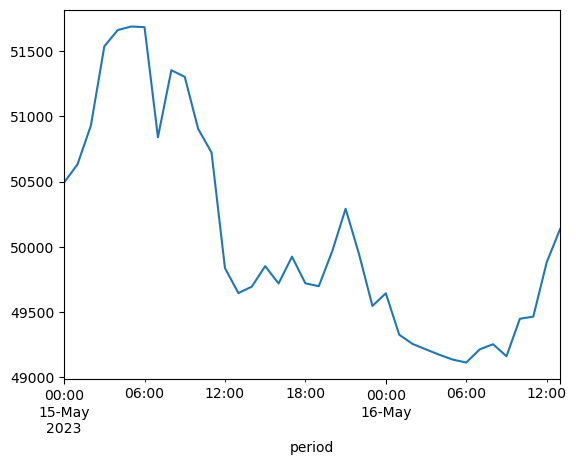

In [156]:
TX_X['pred'].plot()

In [157]:
TX_X

,temp,feelslike,humidity,dew,precip,precipprob,snow,snowdepth,windspeed,winddir,sealevelevelpressure,visibility,cloudcover,solarradiation,uvindex,year,month,days,hour,quarter,dayofyear,AdjClose,Adj_Close_30D_lag,Adj_Close_60D_lag,Holiday_ChristmasDay,Holiday_ChristmasDaysubstitute,Holiday_ChristmasEve,Holiday_CincodeMayo,Holiday_ColumbusDay,Holiday_DayAfterChristmasDay,Holiday_EasterMonday,Holiday_EasterSunday,Holiday_ElectionDay,Holiday_ElectionDayGeneralElection,Holiday_FathersDay,Holiday_FlagDay,Holiday_Halloween,Holiday_InaugurationDay,Holiday_IndependenceDay,Holiday_IndependenceDaysubstitute,Holiday_Juneteenth,Holiday_Juneteenthsubstitute,Holiday_LaborDay,Holiday_MartinLutherKingJrDay,Holiday_MemorialDay,Holiday_MothersDay,Holiday_NewYearsDay,Holiday_NewYearsDaysubstitute,Holiday_NewYearsEve,Holiday_PresidentsDay,Holiday_StPatricksDay,Holiday_SuperTuesday,Holiday_TaxDay,Holiday_ThanksgivingDay,Holiday_ValentinesDay,Holiday_VeteransDay,Holiday_VeteransDaysubstitute,IsWeekend_True,demand_3d_lag,24_hours_ahead,pred
period,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-05-15 00:00:00,80.0,80.0,67.91,68.4,0.000,0.0,0.0,NaN,6.5,100.0,1016.9,9.8,38.2,80.0,1.0,2023,5.0,0.0,0.0,2.0,135,32.16,32.880001,30.827000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48928.319444,67.1,50492.364090
2023-05-15 01:00:00,78.5,78.5,69.84,67.9,0.000,0.0,0.0,NaN,4.0,112.0,1017.4,9.8,20.5,14.0,0.0,2023,5.0,0.0,1.0,2.0,135,32.16,32.880001,30.827000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48676.507042,70.9,50631.946895
2023-05-15 02:00:00,76.4,76.4,76.80,68.6,0.000,0.0,0.0,NaN,3.5,89.0,1018.0,9.5,20.5,201.0,0.0,2023,5.0,0.0,2.0,2.0,135,32.16,32.880001,30.827000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48479.246377,74.3,50929.431587
2023-05-15 03:00:00,74.3,74.3,79.75,67.6,0.000,0.0,0.0,NaN,0.0,0.0,1018.7,9.7,20.5,16.0,0.0,2023,5.0,0.0,3.0,2.0,135,32.16,32.880001,30.827000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48445.298507,78.3,51534.979051
2023-05-15 04:00:00,73.0,73.0,83.45,67.6,0.000,0.0,0.0,NaN,0.3,5.0,1019.4,9.9,20.5,10.0,0.0,2023,5.0,0.0,4.0,2.0,135,32.16,32.880001,30.827000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48532.030769,81.0,51659.850470
2023-05-15 05:00:00,72.9,72.9,83.45,67.5,0.000,0.0,0.0,NaN,2.6,76.0,1019.4,9.8,22.0,12.0,0.0,2023,5.0,0.0,5.0,2.0,135,32.16,32.880001,30.827000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48672.619048,82.1,51687.164333
2023-05-15 06:00:00,71.5,71.5,88.13,67.8,0.000,0.0,0.0,NaN,0.0,0.0,1019.9,9.4,82.5,12.0,0.0,2023,5.0,0.0,6.0,2.0,135,32.16,32.880001,30.827000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48739.918033,84.3,51682.363406
2023-05-15 07:00:00,67.0,67.0,100.00,67.0,0.000,0.0,0.0,NaN,2.7,360.0,1019.7,8.7,60.0,12.0,0.0,2023,5.0,0.0,7.0,2.0,135,32.16,32.880001,30.827000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48715.423729,74.3,50839.159061
2023-05-15 08:00:00,70.8,70.8,93.27,68.8,0.000,0.0,0.0,NaN,0.0,0.0,1019.5,9.9,88.7,12.0,0.0,2023,5.0,0.0,8.0,2.0,135,32.16,32.880001,30.827000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48555.526316,75.4,51352.521239
